## 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive
%cd ANDL_HOMEWORK2_LINK

Mounted at /gdrive
/gdrive/My Drive
/gdrive/.shortcut-targets-by-id/1vsTygZGT_kAzNeU8X79sw_R-6RcOwzqm/Homework 2


## ⚙️ Import Libraries

In [ ]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


## ⏳ Load the Data

In [ ]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 1000

# Set data split size for training and validation
SPLITS_SIZE = 0.2

# Dataset Training
trainset_filename = "preprocessed_dataset/augm_training_dataset.npz"

# Dataset Test
testset_filename = "dataset/test_dataset.npz"

In [ ]:
training_data = np.load(trainset_filename)

X_train = training_data["images"]
y_train = training_data["labels"]

test_data = np.load(testset_filename)
X_test = test_data["images"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (8780, 64, 128)
Training y shape: (8780, 64, 128)
Test X shape: (10022, 64, 128)


In [ ]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
y_train = y_train[..., np.newaxis]
X_test = X_test[..., np.newaxis] / 255.0

INPUT_SHAPE = X_train.shape[1:]
NUM_CLASSES = len(np.unique(y_train))

print(f"Input shape: {INPUT_SHAPE}")
print(f"Number of classes: {NUM_CLASSES}")

Input shape: (64, 128, 1)
Number of classes: 5


In [ ]:
def display_images(images, labels, num_images):
    mod_labels = labels[..., np.newaxis] / 255.0
    num_images = min(num_images, len(images))

    if num_images == 0:
      return

    random_indices = np.random.choice(len(images), num_images, replace=False)

    num_images *= 2

    cols = min(num_images, 2) * 2 # Limit to 5 columns for readability
    rows = (num_images + cols - 1) // cols  # Calculate the number of rows needed

    fig, ax = plt.subplots(rows, cols, figsize=(32, 64))
    axf = ax.flatten()

    for ax in axf:
        ax.axis('off')

    for i, idx in enumerate(random_indices):
        axf[(i * 2)].imshow(images[idx].squeeze(), cmap='gray' if images[idx].ndim == 2 else None)
        axf[(i * 2) + 1].imshow(mod_labels[idx].squeeze(), cmap='gray' if mod_labels[idx].ndim == 2 else None)

    plt.tight_layout()
    plt.show()

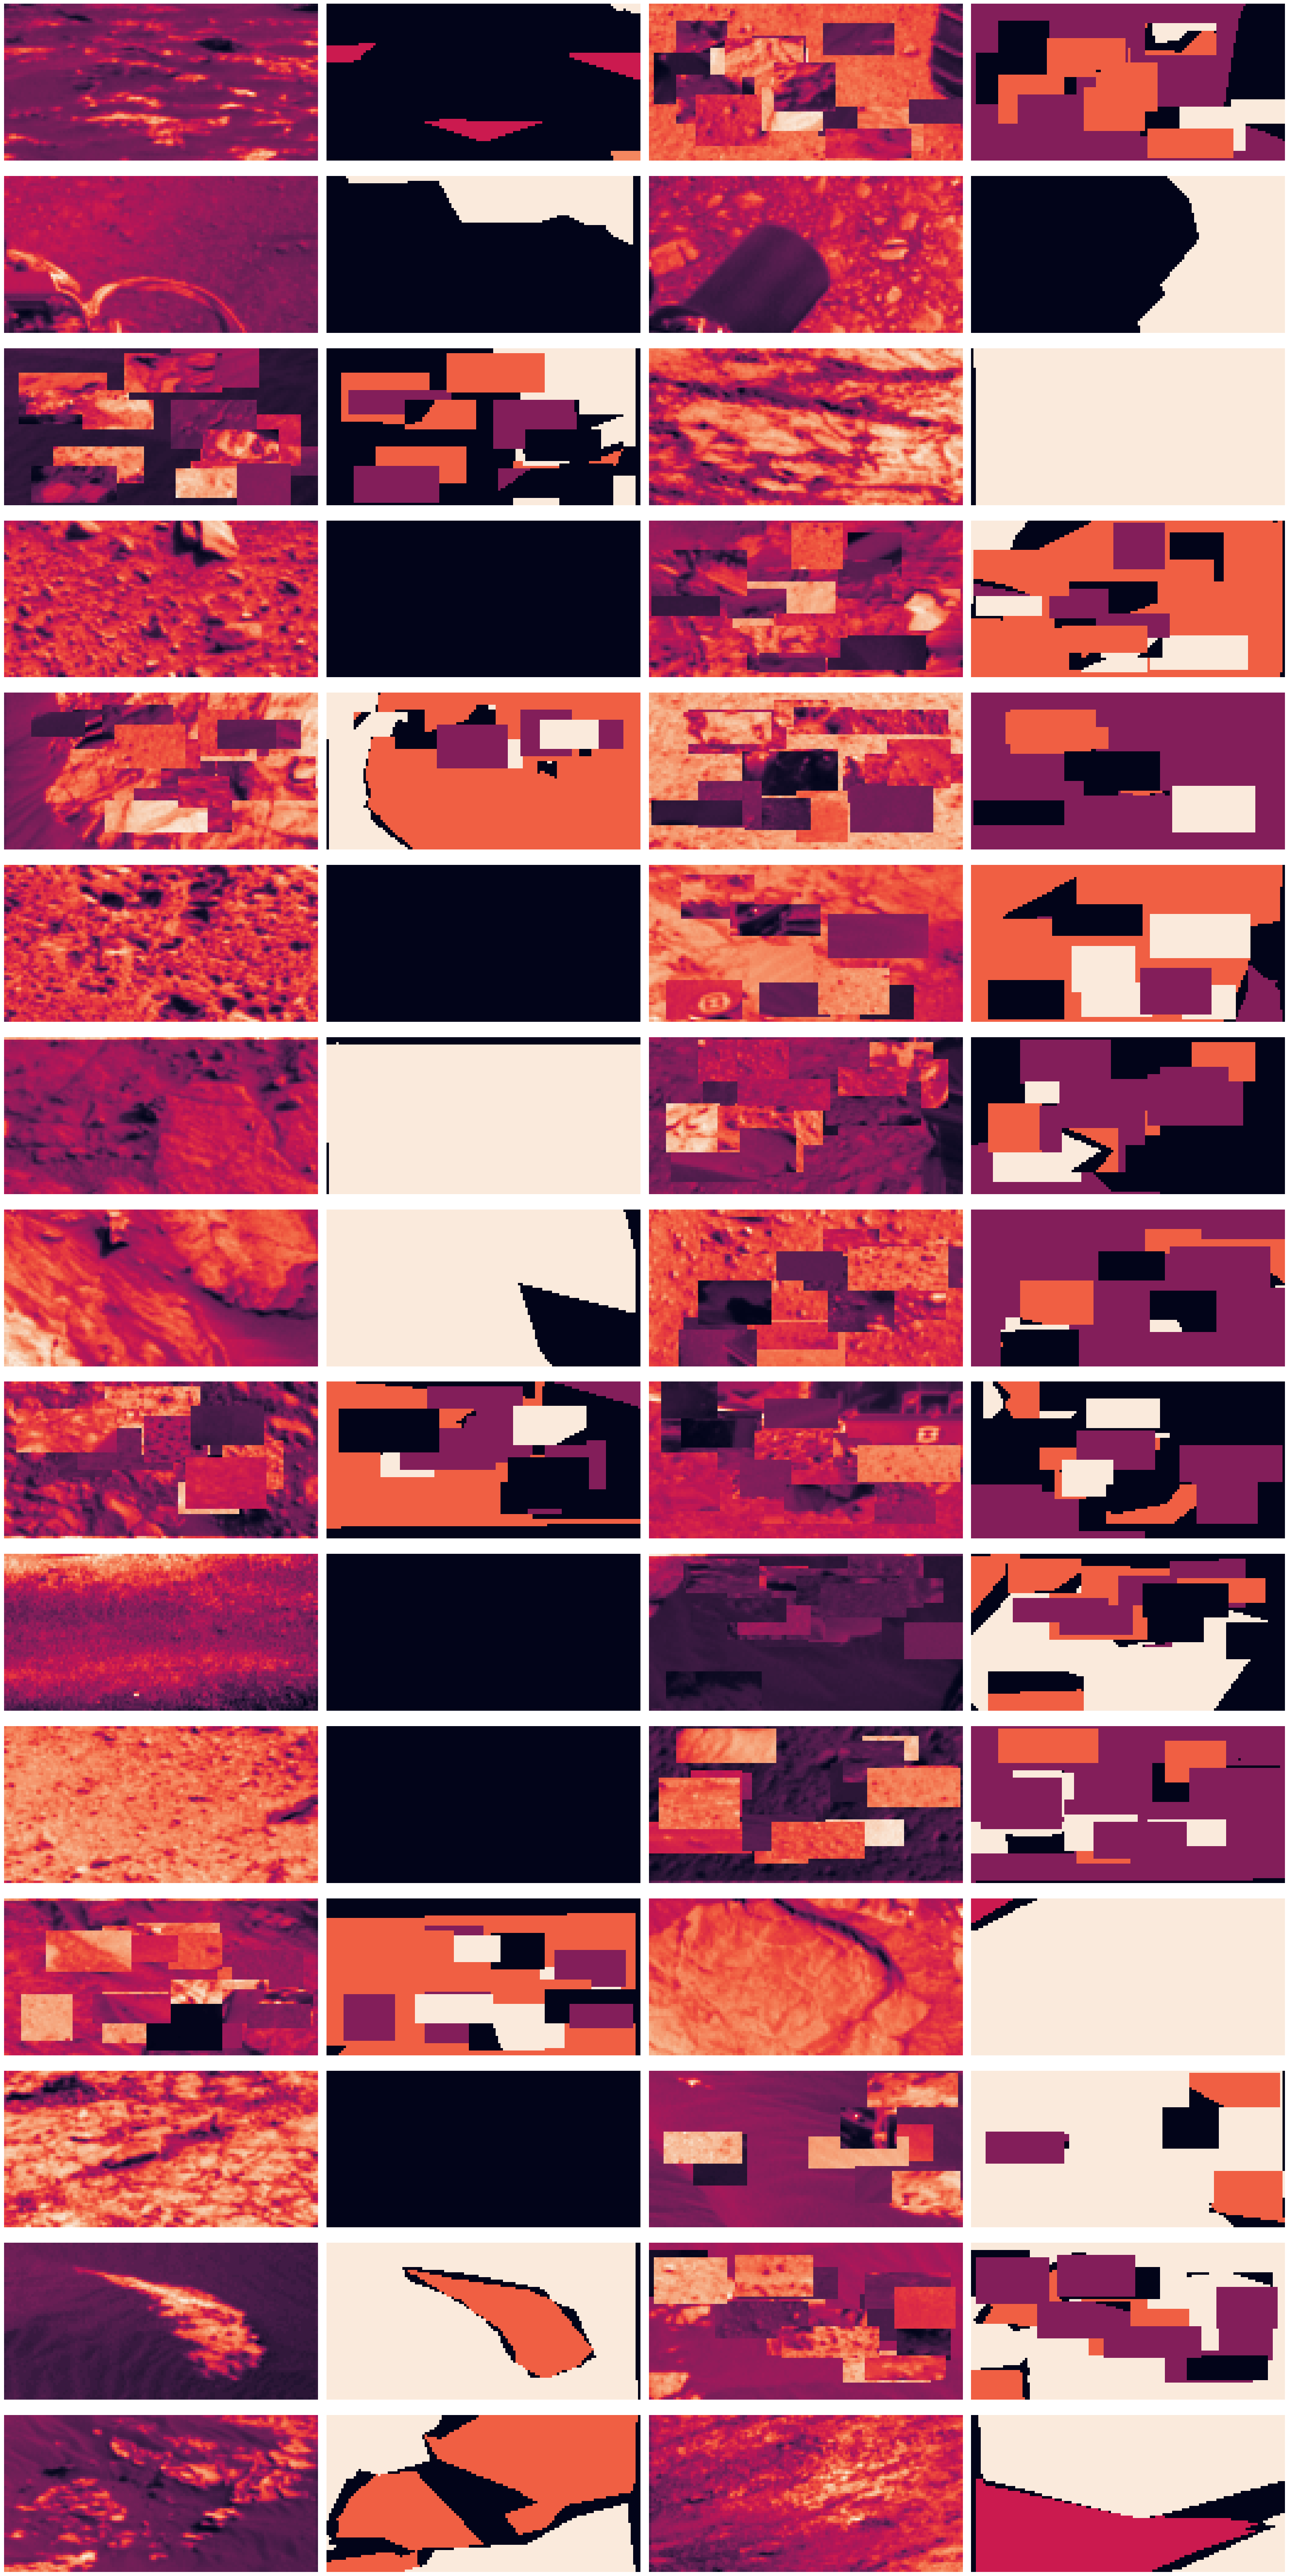

In [ ]:
display_images(X_train, y_train, 30)

In [ ]:
# Split into training, validation
print("Splitting data...")
train_img, val_img, train_lbl, val_lbl = train_test_split(
    X_train, y_train, test_size=0.2, random_state=seed
)

print("Data splitted!")

print(f"\nNumber of images:")
print(f"Train: {len(train_img)}")
print(f"Validation: {len(val_img)}")

Splitting data...
Data splitted!

Number of images:
Train: 7024
Validation: 1756


In [ ]:
@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label

def make_dataset(images, labels, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    if augment:
        dataset = dataset.map(
            lambda x, y: random_flip(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    train_img, train_lbl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
Datasets created!

Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128, 1)
Labels dtype: <dtype: 'float64'>


Visualizing examples from the training set:


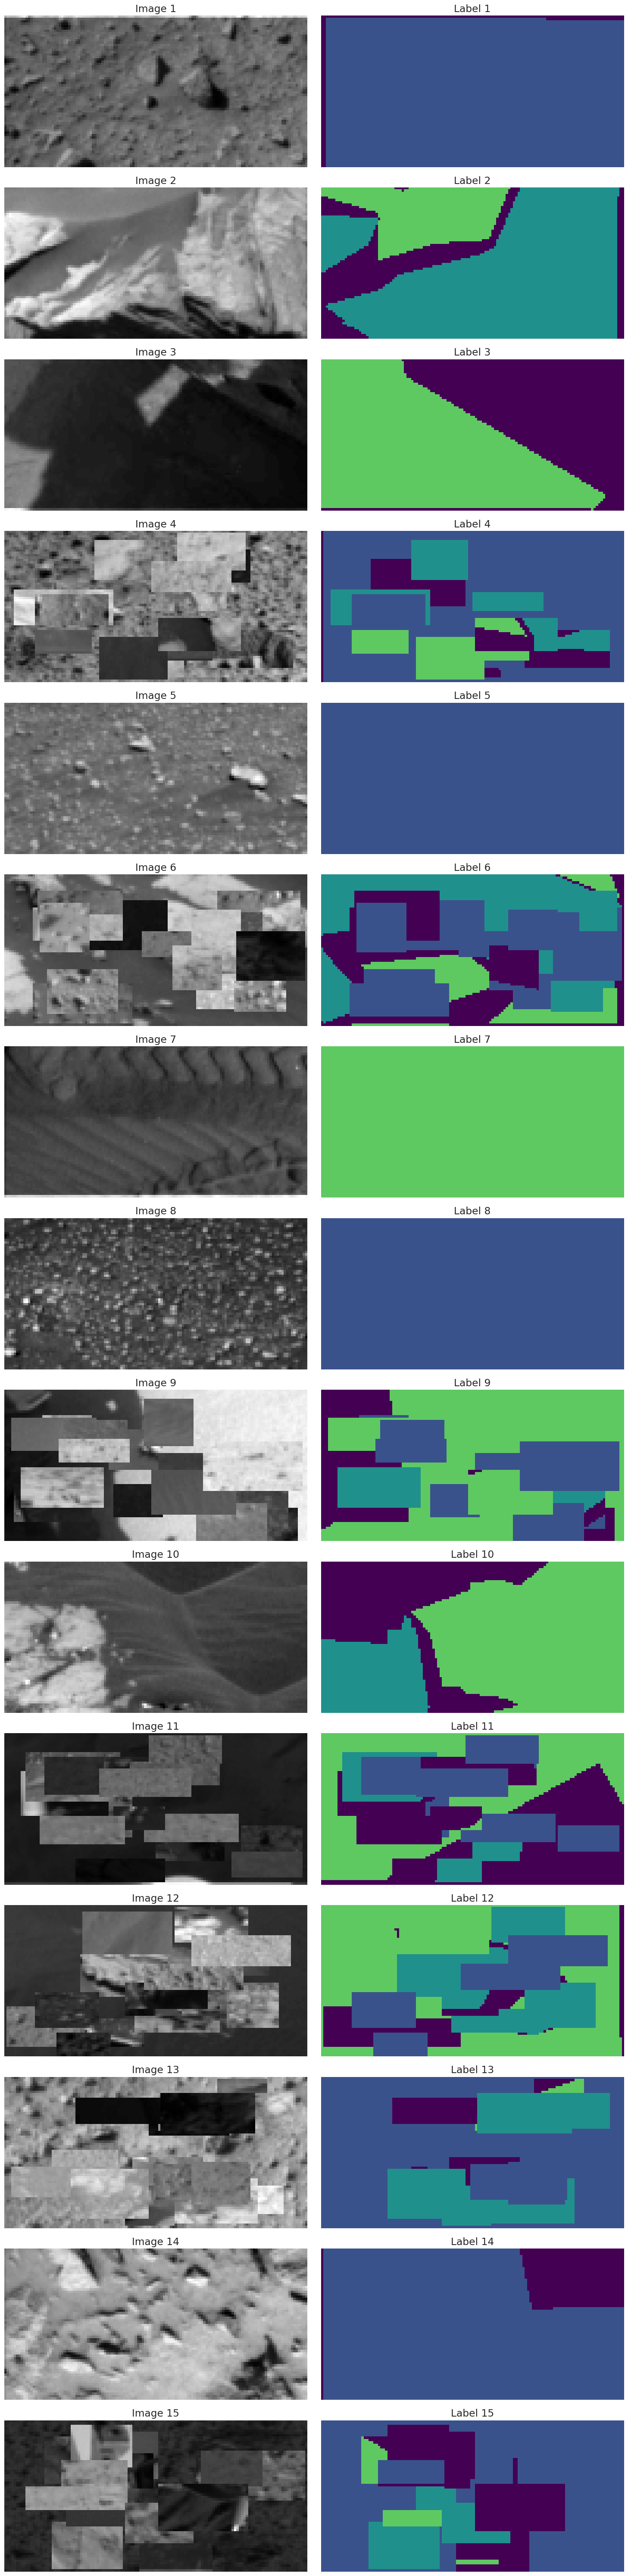

In [ ]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4*num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original image
            plt.subplot(num_samples, 2, j*2 + 1)
            plt.imshow(images[j], cmap='gray')
            plt.title(f'Image {j+1}')
            plt.axis('off')

            # Plot colored label
            plt.subplot(num_samples, 2, j*2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)
            plt.imshow(colored_label)
            plt.title(f'Label {j+1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(train_dataset, num_samples=15)

## 🛠️ Train and Save the Model

In [ ]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [ ]:
def get_unet_model(input_shape, num_classes, seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck
    bottleneck = unet_block(d2, 128, name='bottleneck')

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_2])
    u1 = unet_block(u1, 64, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_1])
    u2 = unet_block(u2, 32, name='up_block2_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

In [ ]:
model = get_unet_model(INPUT_SHAPE, NUM_CLASSES, seed)

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70, to_file='temp_model.png')
%rm temp_model.png

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv1      │ (None, 64, 128, 32)  │          320 │ input_layer[0][0]   │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn1        │ (None, 64, 128, 32)  │          128 │ down_block1_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv2      │ (None, 64, 128, 32)  │        9,248 │ down_block1_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn2        │ (None, 64, 128, 32)  │          128 │ down_block1_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn2[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d          │ (None, 32, 64, 32)   │            0 │ down_block1_activa… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv1      │ (None, 32, 64, 64)   │       18,496 │ max_pooling2d[0][0] │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn1        │ (None, 32, 64, 64)   │          256 │ down_block2_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_activatio… │ (None, 32, 64, 64)   │            0 │ down_block2_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv2      │ (None, 32, 64, 64)   │       36,928 │ down_block2_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn2        │ (None, 32, 64, 64)   │          256 │ down_block2_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├──────────────────────

 Total params: 473,669 (1.81 MB)

 Trainable params: 472,389 (1.80 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [ ]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, frequency=5):
        super().__init__()
        self.lastR = 0
        self.images = image
        self.labels = label
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            last_img = self.images[self.lastR]
            last_lbl = self.labels[self.lastR]

            r = np.random.randint(0, len(self.images))
            image = self.images[r]
            label = self.labels[r]

            self.lastR = r

            last_img = tf.expand_dims(last_img, 0)
            last_lbl = tf.expand_dims(last_lbl, 0)

            image = tf.expand_dims(image, 0)
            label = tf.expand_dims(label, 0)

            last_pred = self.model.predict(last_img, verbose=0)
            y_last_pred = tf.math.argmax(last_pred, axis=-1)
            y_last_pred = y_last_pred.numpy()

            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(2, 3, 1)
            plt.imshow(last_img[0])
            plt.title("Last Input Image")
            plt.axis('off')

            plt.subplot(2,3,4)
            plt.imshow(image[0])
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(2, 3, 2)
            colored_last_label = apply_colormap(last_lbl.numpy(), colormap)
            plt.imshow(colored_last_label)
            plt.title("Last Ground Truth Mask")
            plt.axis('off')

            plt.subplot(2,3,5)
            colored_label = apply_colormap(label.numpy(), colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(2, 3, 3)
            colored_last_pred = apply_colormap(y_last_pred[0], colormap)
            plt.imshow(colored_last_pred)
            plt.title("Last Predicted Mask")
            plt.axis('off')

            plt.subplot(2,3,6)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [ ]:
# Compile the model
print("Compiling model...")
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.AdamW(),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)
print("Model compiled!")

Compiling model...
Model compiled!


In [ ]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

reduce_lr_on_plateau = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_mean_iou',
    factor=0.2,
    patience=5
    )

viz_callback = VizCallback(val_img, val_lbl)

Epoch 1/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.3981 - loss: 1.4220 - mean_iou: 0.1860

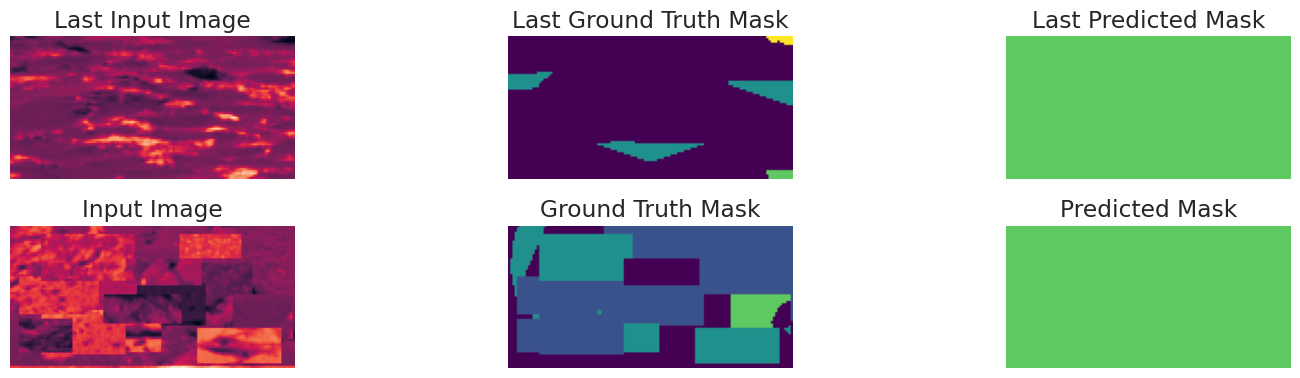

110/110 ━━━━━━━━━━━━━━━━━━━━ 90s 467ms/step - accuracy: 0.3988 - loss: 1.4206 - mean_iou: 0.1864 - val_accuracy: 0.1825 - val_loss: 3.6599 - val_mean_iou: 0.0600 - learning_rate: 0.0010
Epoch 2/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.5631 - loss: 1.0678 - mean_iou: 0.2966 - val_accuracy: 0.1825 - val_loss: 5.6487 - val_mean_iou: 0.0480 - learning_rate: 0.0010
Epoch 3/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 14s 123ms/step - accuracy: 0.6046 - loss: 0.9706 - mean_iou: 0.3321 - val_accuracy: 0.1826 - val_loss: 4.6693 - val_mean_iou: 0.0600 - learning_rate: 0.0010
Epoch 4/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - accuracy: 0.6215 - loss: 0.9300 - mean_iou: 0.3470 - val_accuracy: 0.1850 - val_loss: 3.9769 - val_mean_iou: 0.0493 - learning_rate: 0.0010
Epoch 5/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.6351 - loss: 0.9008 - mean_iou: 0.3596 - val_accuracy: 0.2197 - val_loss: 3.3125 - val_mean_iou: 0.0748 - learning_rate: 0.0010
Epoch 6/1000
110/1

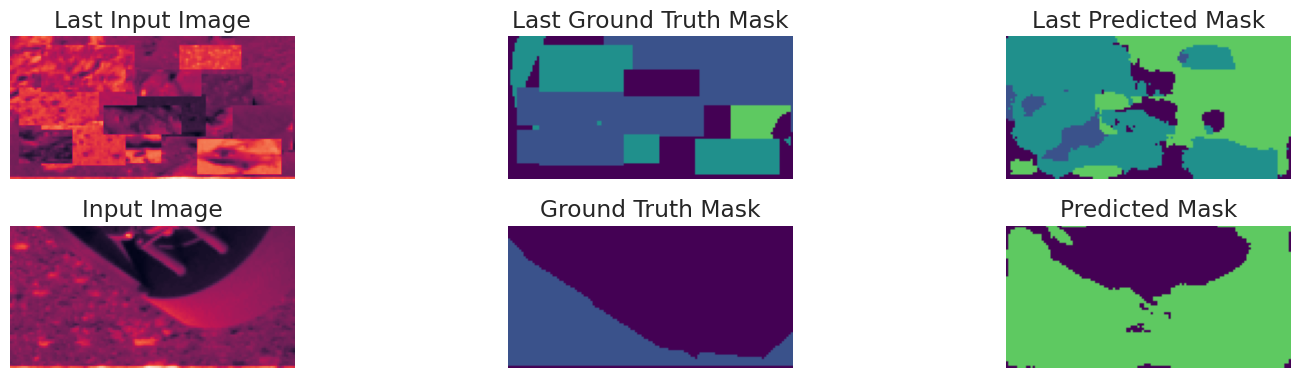

110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 137ms/step - accuracy: 0.6452 - loss: 0.8738 - mean_iou: 0.3677 - val_accuracy: 0.3691 - val_loss: 2.0220 - val_mean_iou: 0.1504 - learning_rate: 0.0010
Epoch 7/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - accuracy: 0.6568 - loss: 0.8528 - mean_iou: 0.3760 - val_accuracy: 0.4072 - val_loss: 1.7356 - val_mean_iou: 0.1474 - learning_rate: 0.0010
Epoch 8/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.6709 - loss: 0.8213 - mean_iou: 0.3887 - val_accuracy: 0.6259 - val_loss: 0.9452 - val_mean_iou: 0.3502 - learning_rate: 2.0000e-04
Epoch 9/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.6835 - loss: 0.7924 - mean_iou: 0.3999 - val_accuracy: 0.5825 - val_loss: 1.0893 - val_mean_iou: 0.3086 - learning_rate: 2.0000e-04
Epoch 10/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - accuracy: 0.6862 - loss: 0.7841 - mean_iou: 0.4015 - val_accuracy: 0.5972 - val_loss: 1.0231 - val_mean_iou: 0.3262 - learning_rate: 2.0000e-04
Epoch

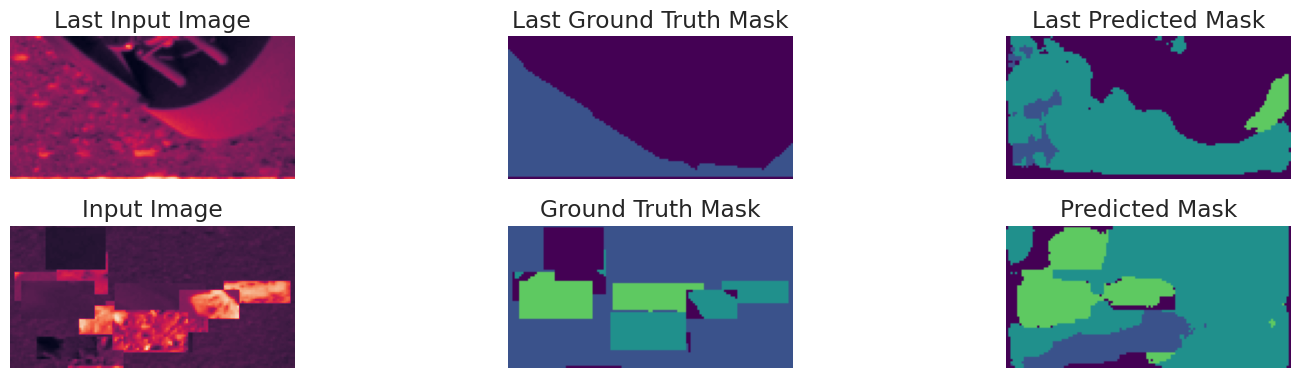

110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 140ms/step - accuracy: 0.6873 - loss: 0.7811 - mean_iou: 0.4031 - val_accuracy: 0.6179 - val_loss: 0.9610 - val_mean_iou: 0.3405 - learning_rate: 2.0000e-04
Epoch 12/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 19s 129ms/step - accuracy: 0.6906 - loss: 0.7762 - mean_iou: 0.4054 - val_accuracy: 0.6611 - val_loss: 0.8584 - val_mean_iou: 0.3815 - learning_rate: 2.0000e-04
Epoch 13/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.6971 - loss: 0.7596 - mean_iou: 0.4119 - val_accuracy: 0.6903 - val_loss: 0.7682 - val_mean_iou: 0.4068 - learning_rate: 4.0000e-05
Epoch 14/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.6985 - loss: 0.7550 - mean_iou: 0.4131 - val_accuracy: 0.6958 - val_loss: 0.7564 - val_mean_iou: 0.4137 - learning_rate: 4.0000e-05
Epoch 15/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - accuracy: 0.6996 - loss: 0.7536 - mean_iou: 0.4133 - val_accuracy: 0.7016 - val_loss: 0.7405 - val_mean_iou: 0.4190 - learning_rate: 4.000

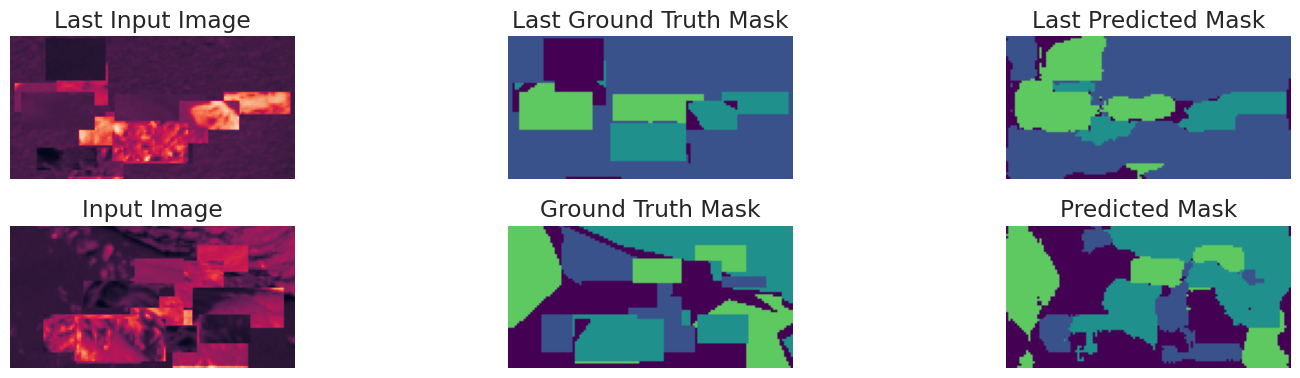

110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 140ms/step - accuracy: 0.7009 - loss: 0.7503 - mean_iou: 0.4145 - val_accuracy: 0.7013 - val_loss: 0.7422 - val_mean_iou: 0.4163 - learning_rate: 4.0000e-05
Epoch 17/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 19s 128ms/step - accuracy: 0.7016 - loss: 0.7492 - mean_iou: 0.4147 - val_accuracy: 0.7018 - val_loss: 0.7402 - val_mean_iou: 0.4197 - learning_rate: 4.0000e-05
Epoch 18/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.7009 - loss: 0.7506 - mean_iou: 0.4147 - val_accuracy: 0.7074 - val_loss: 0.7288 - val_mean_iou: 0.4179 - learning_rate: 8.0000e-06
Epoch 19/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.7027 - loss: 0.7469 - mean_iou: 0.4161 - val_accuracy: 0.7078 - val_loss: 0.7279 - val_mean_iou: 0.4183 - learning_rate: 8.0000e-06
Epoch 20/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.7035 - loss: 0.7450 - mean_iou: 0.4170 - val_accuracy: 0.7080 - val_loss: 0.7274 - val_mean_iou: 0.4182 - learning_rate: 8.000

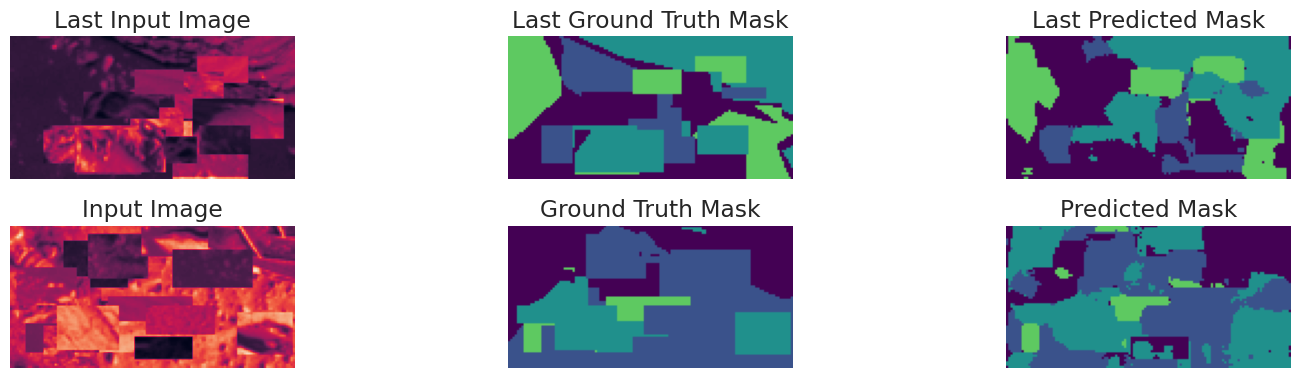

110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 137ms/step - accuracy: 0.7030 - loss: 0.7448 - mean_iou: 0.4163 - val_accuracy: 0.7084 - val_loss: 0.7270 - val_mean_iou: 0.4180 - learning_rate: 8.0000e-06
Epoch 22/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.7043 - loss: 0.7427 - mean_iou: 0.4171 - val_accuracy: 0.7084 - val_loss: 0.7268 - val_mean_iou: 0.4179 - learning_rate: 8.0000e-06
Epoch 23/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - accuracy: 0.7041 - loss: 0.7417 - mean_iou: 0.4173 - val_accuracy: 0.7088 - val_loss: 0.7260 - val_mean_iou: 0.4182 - learning_rate: 1.6000e-06
Epoch 24/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.7039 - loss: 0.7453 - mean_iou: 0.4163 - val_accuracy: 0.7090 - val_loss: 0.7257 - val_mean_iou: 0.4182 - learning_rate: 1.6000e-06
Epoch 25/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.7058 - loss: 0.7390 - mean_iou: 0.4186 - val_accuracy: 0.7091 - val_loss: 0.7254 - val_mean_iou: 0.4183 - learning_rate: 1.600

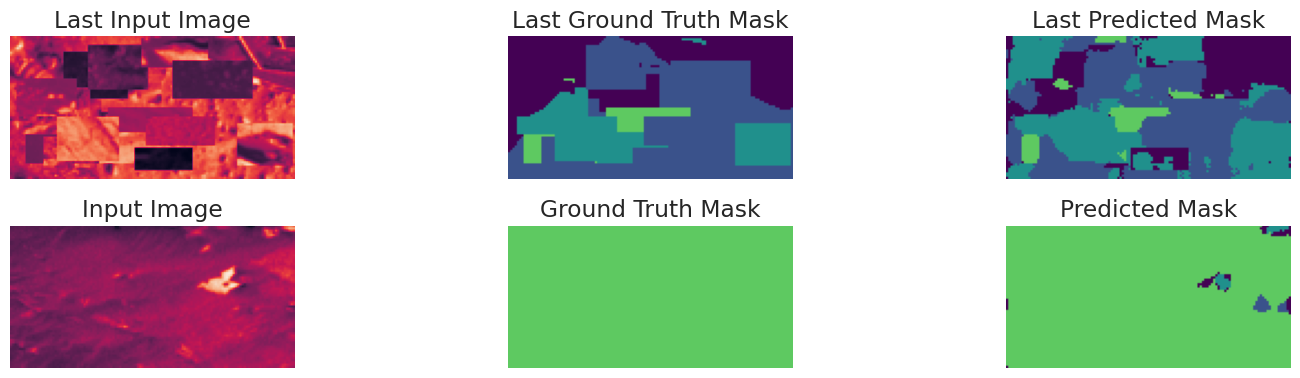

110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - accuracy: 0.7049 - loss: 0.7412 - mean_iou: 0.4184 - val_accuracy: 0.7091 - val_loss: 0.7255 - val_mean_iou: 0.4182 - learning_rate: 1.6000e-06
Epoch 27/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 0.7060 - loss: 0.7381 - mean_iou: 0.4188 - val_accuracy: 0.7093 - val_loss: 0.7251 - val_mean_iou: 0.4185 - learning_rate: 1.6000e-06
Epoch 28/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 127ms/step - accuracy: 0.7032 - loss: 0.7431 - mean_iou: 0.4158 - val_accuracy: 0.7092 - val_loss: 0.7252 - val_mean_iou: 0.4184 - learning_rate: 3.2000e-07
Epoch 29/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.7038 - loss: 0.7438 - mean_iou: 0.4184 - val_accuracy: 0.7092 - val_loss: 0.7252 - val_mean_iou: 0.4183 - learning_rate: 3.2000e-07
Epoch 30/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.7043 - loss: 0.7433 - mean_iou: 0.4169 - val_accuracy: 0.7092 - val_loss: 0.7252 - val_mean_iou: 0.4183 - learning_rate: 3.200

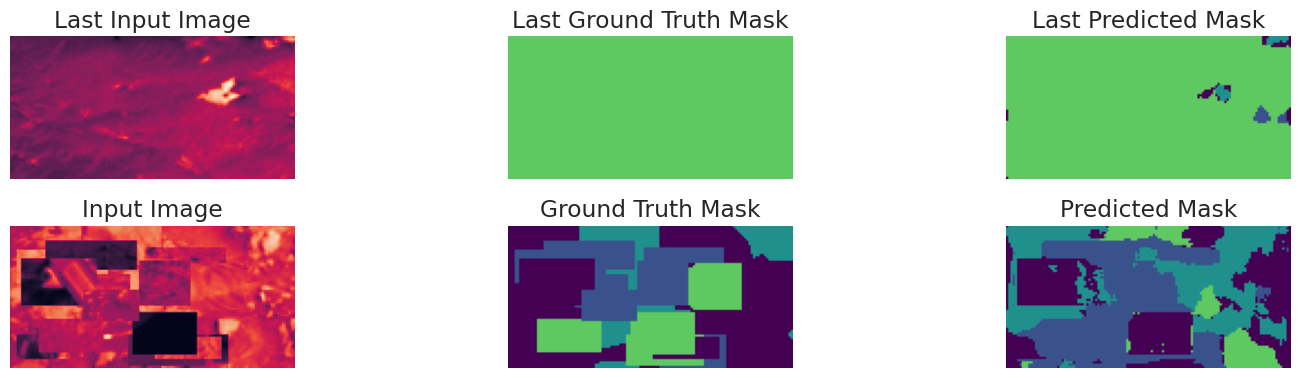

110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 137ms/step - accuracy: 0.7042 - loss: 0.7422 - mean_iou: 0.4169 - val_accuracy: 0.7092 - val_loss: 0.7252 - val_mean_iou: 0.4183 - learning_rate: 3.2000e-07
Epoch 32/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 19s 127ms/step - accuracy: 0.7037 - loss: 0.7434 - mean_iou: 0.4162 - val_accuracy: 0.7092 - val_loss: 0.7252 - val_mean_iou: 0.4183 - learning_rate: 3.2000e-07
Epoch 33/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - accuracy: 0.7051 - loss: 0.7411 - mean_iou: 0.4183 - val_accuracy: 0.7092 - val_loss: 0.7252 - val_mean_iou: 0.4184 - learning_rate: 6.4000e-08
Epoch 34/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - accuracy: 0.7041 - loss: 0.7442 - mean_iou: 0.4162 - val_accuracy: 0.7092 - val_loss: 0.7252 - val_mean_iou: 0.4184 - learning_rate: 6.4000e-08
Epoch 35/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 0.7036 - loss: 0.7435 - mean_iou: 0.4160 - val_accuracy: 0.7092 - val_loss: 0.7251 - val_mean_iou: 0.4184 - learning_rate: 6.400

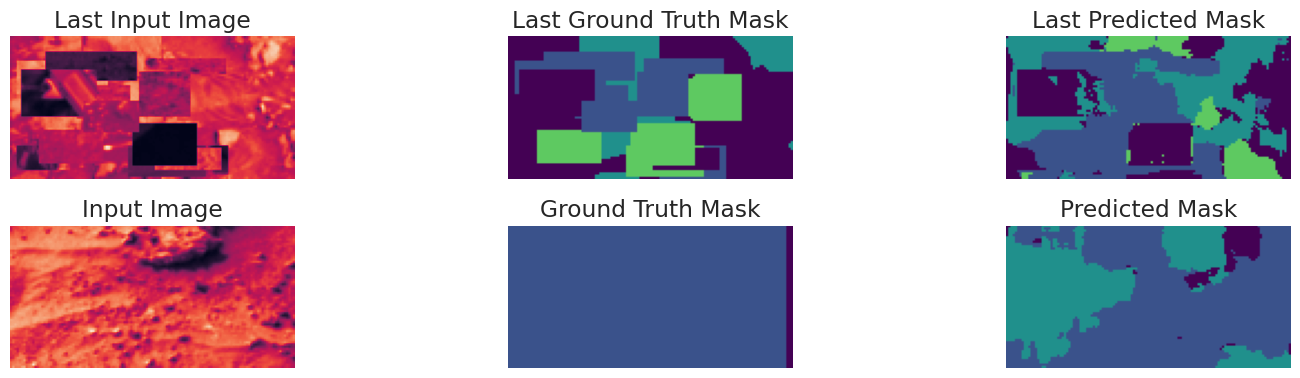

110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - accuracy: 0.7054 - loss: 0.7405 - mean_iou: 0.4181 - val_accuracy: 0.7092 - val_loss: 0.7251 - val_mean_iou: 0.4184 - learning_rate: 6.4000e-08
Epoch 37/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - accuracy: 0.7048 - loss: 0.7406 - mean_iou: 0.4176 - val_accuracy: 0.7092 - val_loss: 0.7252 - val_mean_iou: 0.4184 - learning_rate: 6.4000e-08
Epoch 38/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.7054 - loss: 0.7397 - mean_iou: 0.4187 - val_accuracy: 0.7092 - val_loss: 0.7252 - val_mean_iou: 0.4184 - learning_rate: 1.2800e-08
Epoch 39/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.7044 - loss: 0.7419 - mean_iou: 0.4167 - val_accuracy: 0.7092 - val_loss: 0.7251 - val_mean_iou: 0.4184 - learning_rate: 1.2800e-08
Epoch 40/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.7055 - loss: 0.7406 - mean_iou: 0.4179 - val_accuracy: 0.7092 - val_loss: 0.7251 - val_mean_iou: 0.4184 - learning_rate: 1.280

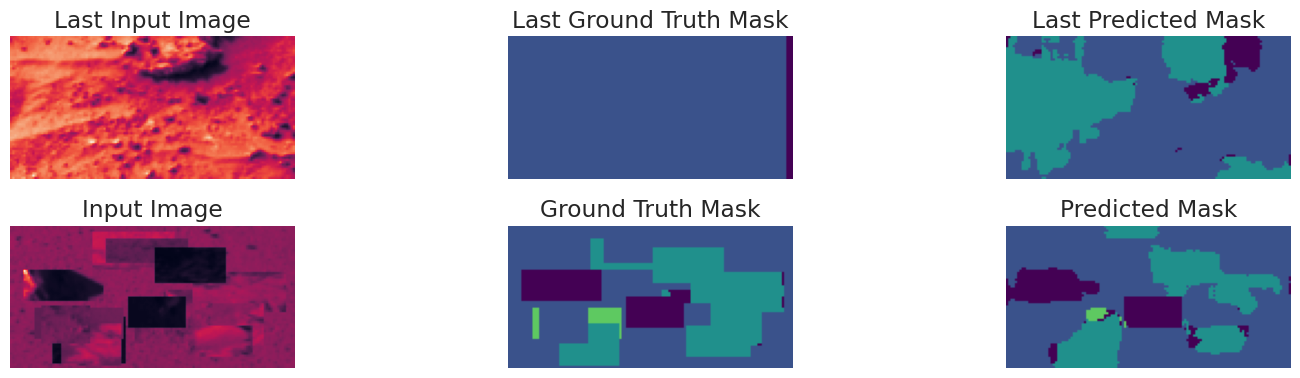

110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 137ms/step - accuracy: 0.7043 - loss: 0.7418 - mean_iou: 0.4171 - val_accuracy: 0.7092 - val_loss: 0.7251 - val_mean_iou: 0.4185 - learning_rate: 1.2800e-08
Epoch 42/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 19s 128ms/step - accuracy: 0.7056 - loss: 0.7395 - mean_iou: 0.4181 - val_accuracy: 0.7092 - val_loss: 0.7251 - val_mean_iou: 0.4184 - learning_rate: 1.2800e-08
Epoch 43/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.7055 - loss: 0.7405 - mean_iou: 0.4180 - val_accuracy: 0.7092 - val_loss: 0.7251 - val_mean_iou: 0.4185 - learning_rate: 2.5600e-09
Epoch 44/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - accuracy: 0.7039 - loss: 0.7420 - mean_iou: 0.4167 - val_accuracy: 0.7092 - val_loss: 0.7252 - val_mean_iou: 0.4184 - learning_rate: 2.5600e-09
Epoch 45/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.7061 - loss: 0.7392 - mean_iou: 0.4185 - val_accuracy: 0.7092 - val_loss: 0.7252 - val_mean_iou: 0.4183 - learning_rate: 2.560

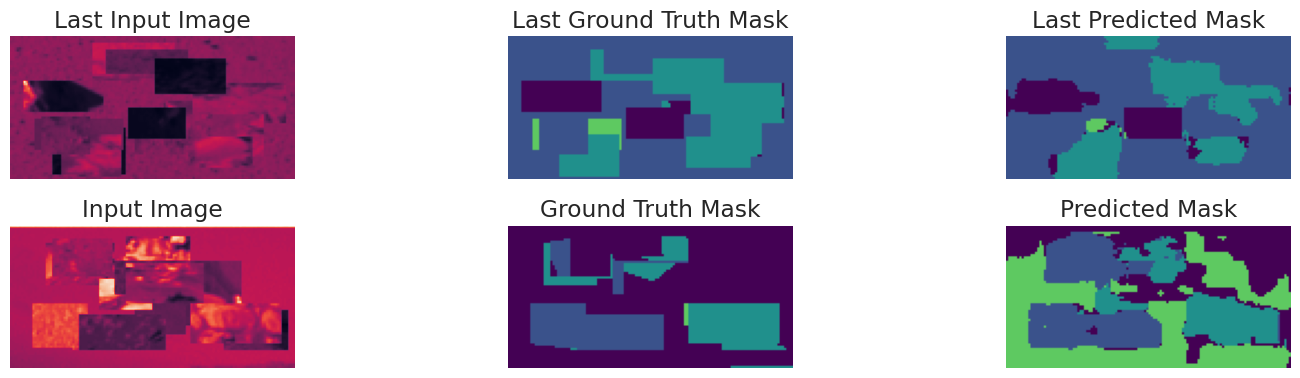

110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 137ms/step - accuracy: 0.7052 - loss: 0.7415 - mean_iou: 0.4180 - val_accuracy: 0.7092 - val_loss: 0.7252 - val_mean_iou: 0.4184 - learning_rate: 2.5600e-09
Epoch 47/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 19s 128ms/step - accuracy: 0.7067 - loss: 0.7383 - mean_iou: 0.4186 - val_accuracy: 0.7092 - val_loss: 0.7251 - val_mean_iou: 0.4184 - learning_rate: 2.5600e-09
Epoch 48/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.7044 - loss: 0.7430 - mean_iou: 0.4173 - val_accuracy: 0.7092 - val_loss: 0.7251 - val_mean_iou: 0.4185 - learning_rate: 5.1200e-10
Epoch 49/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.7052 - loss: 0.7418 - mean_iou: 0.4172 - val_accuracy: 0.7092 - val_loss: 0.7251 - val_mean_iou: 0.4184 - learning_rate: 5.1200e-10
Epoch 50/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.7044 - loss: 0.7409 - mean_iou: 0.4174 - val_accuracy: 0.7092 - val_loss: 0.7251 - val_mean_iou: 0.4184 - learning_rate: 5.120

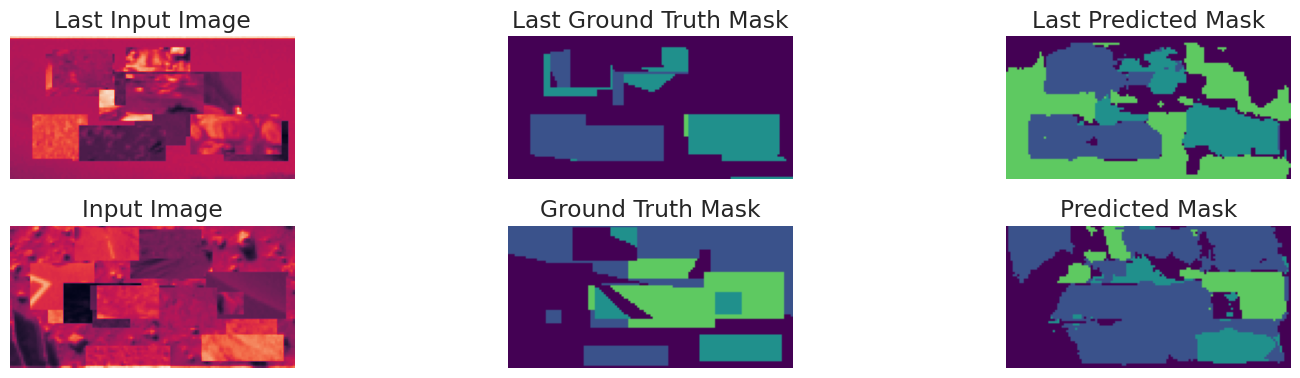

110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 144ms/step - accuracy: 0.7043 - loss: 0.7414 - mean_iou: 0.4171 - val_accuracy: 0.7092 - val_loss: 0.7251 - val_mean_iou: 0.4184 - learning_rate: 5.1200e-10
Epoch 52/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 19s 129ms/step - accuracy: 0.7037 - loss: 0.7444 - mean_iou: 0.4159 - val_accuracy: 0.7092 - val_loss: 0.7251 - val_mean_iou: 0.4184 - learning_rate: 5.1200e-10
Epoch 53/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.7054 - loss: 0.7395 - mean_iou: 0.4178 - val_accuracy: 0.7092 - val_loss: 0.7251 - val_mean_iou: 0.4184 - learning_rate: 1.0240e-10
Epoch 54/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 0.7066 - loss: 0.7377 - mean_iou: 0.4197 - val_accuracy: 0.7092 - val_loss: 0.7251 - val_mean_iou: 0.4184 - learning_rate: 1.0240e-10
Epoch 55/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.7045 - loss: 0.7420 - mean_iou: 0.4170 - val_accuracy: 0.7092 - val_loss: 0.7251 - val_mean_iou: 0.4184 - learning_rate: 1.024

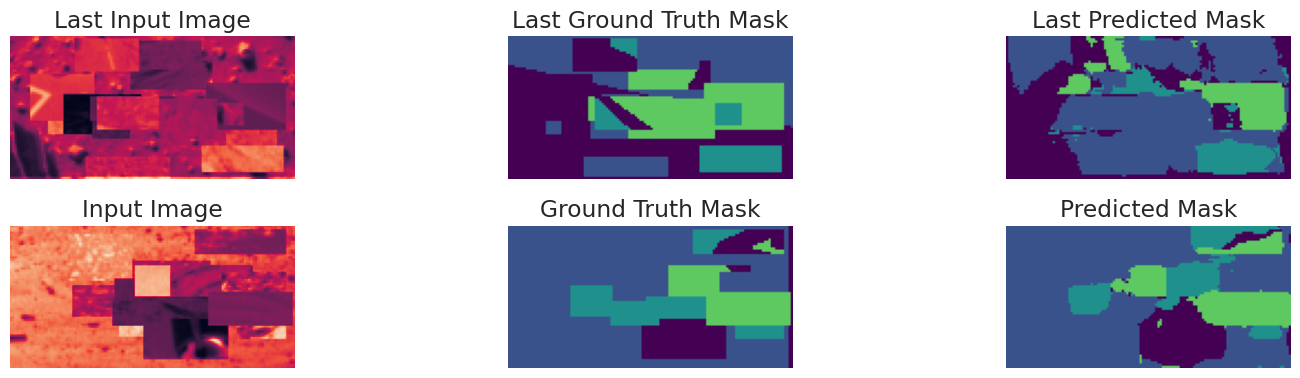

110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - accuracy: 0.7040 - loss: 0.7422 - mean_iou: 0.4170 - val_accuracy: 0.7092 - val_loss: 0.7251 - val_mean_iou: 0.4184 - learning_rate: 1.0240e-10
Epoch 57/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.7041 - loss: 0.7445 - mean_iou: 0.4172 - val_accuracy: 0.7092 - val_loss: 0.7251 - val_mean_iou: 0.4185 - learning_rate: 1.0240e-10
Final validation Mean Intersection Over Union: 41.97%
Model saved to models/enrico/weights/net_241214_152738.keras


In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback, reduce_lr_on_plateau],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"models/enrico/weights/net_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")